# Defining fuzzy logic system for evaluating TRS performance

<!-- ![load case](../images/TRS_example/load_case.png "Turbine rear structural thermal loads") -->

<p style="text-align:center;">
    <img src="../images/TRS_example/load_case.png" alt="load case" title="Turbine rear structural thermal loads" width="250px" align="center"/>
</p>

This example shows how to evaluate the design margins of a turbine rear structure (TRS) when experiencing thermal loads. Two temperatures affect the TRS' performance. They are the temperature of the nacelle compartment $T_1$ and the temperature of the gas surface $T_1$. The output that we are interested in is the safety factor $n_\textrm{safety}$.

Simulation results tell us that $n_\textrm{safety}$ decreases when the difference ${\lvert}T_2 - T_1{\rvert}$ and vice versa. Based on this qualitative knowledge, we can use ``dmLib`` to quantify these parameters and find out how much change can a TRS absorb.

## Define fuzzy parameters

First let us import all the required tools to define the parameters ``T1``, ``T2``, and ``n_safety`` as fuzzy parameters

In [22]:
from dmLib.fuzzyLib.fuzzyFunction import triangularFunc
from dmLib.fuzzyLib.fuzzySet import fuzzySet
from dmLib.fuzzyLib.fuzzyRule import fuzzyRule
from dmLib.fuzzyLib.fuzzySystem import fuzzySystem

Next we define the **universe** in which our parameters can vary. 
$$
450 \le T_1 \le 250 \\
480 \le T_2 \le 680 \\
1.0 \le n_\text{safety} \le 6.0 \\
$$

In [23]:
import numpy as np

# Generate universe variables
lb = np.array([250, 480, 1.0])
ub = np.array([450, 680, 6.0])
labels = ['T1','T2','n_safety']

universe = np.linspace(lb, ub, 100) # grid for all variables

Next, we define the **membership functions** in the form of a triangular function. The left foot of the triangle is given by ``shapes_lo``, the center of the triangle is given by ``shapes_md``, and the right foot of the triangle is given by ``shapes_hi``.

In [24]:
# Define shape of triangular membership functions
shapes_lo = np.array([lb,               lb,             lb + (ub-lb)/2  ])
shapes_md = np.array([lb + (ub-lb)/4,   lb + (ub-lb)/2, ub - (ub-lb)/4  ])
shapes_hi = np.array([lb + 1*(ub-lb)/2, ub,             ub              ])

Next we create fuzzy set object for each parameter by looping over ``lb``, ``ub``, and ``n_safety`` and visualize the results fuzzy sets.

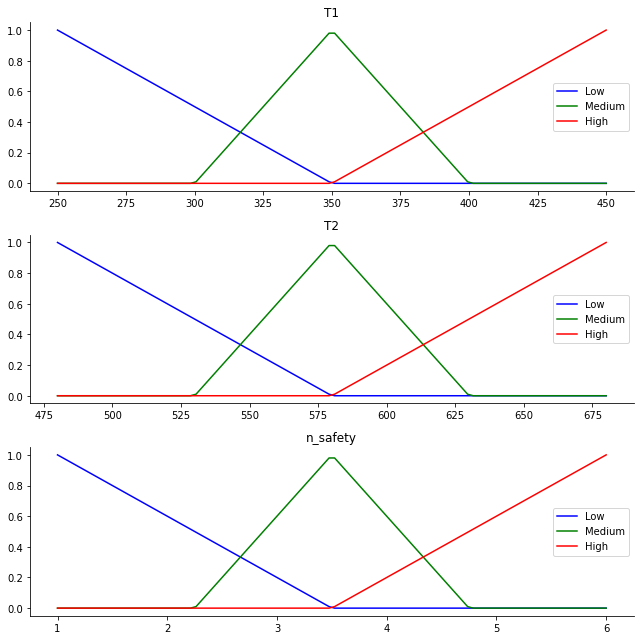

In [25]:
# Generate fuzzy membership functions
fuzzy_sets = []
for i in range(len(lb)):
    lo = triangularFunc(universe[:,i],labels[i])
    lo.setFunc(shapes_lo[0,i],shapes_lo[1,i],shapes_lo[2,i])

    md = triangularFunc(universe[:,i],labels[i])
    md.setFunc(shapes_md[0,i],shapes_md[1,i],shapes_md[2,i])

    hi = triangularFunc(universe[:,i],labels[i])
    hi.setFunc(shapes_hi[0,i],shapes_hi[1,i],shapes_hi[2,i])

    fuzzyset_i = fuzzySet(lo,md,hi,labels[i])

    fuzzy_sets += [fuzzyset_i]

# label each fuzzy set
temp_T1 = fuzzy_sets[0]
temp_T2 = fuzzy_sets[1]
n_safety = fuzzy_sets[2]

# Visualize these universes and membership functions
import matplotlib.pyplot as plt

fig, axis = plt.subplots(nrows=3, figsize=(9, 9))

i = 1
for ax,var,label in zip(axis,fuzzy_sets,labels):

    ax.plot(var.universe, var.lo.getArray(), 'b', linewidth=1.5, label='Low')
    ax.plot(var.universe, var.md.getArray(), 'g', linewidth=1.5, label='Medium')
    ax.plot(var.universe, var.hi.getArray(), 'r', linewidth=1.5, label='High')
    ax.set_title(label)
    ax.legend()

    i += 1

# Turn off top/right axes
for ax in axis:
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()

plt.tight_layout()

## Define fuzzy rules

Next we define the **fuzzy rules** needed to infer the value of ``n_safety``. The **antecedents** are ``T1`` and ``T2`` and the **consequent** is ``n_safety``.
The following fuzzy rules should be applied in our fuzzy logic system:

<table>
  <tr> <th>Rule</th><th>T1</th><th>Operator</th> <th>T2</th> <th>n_safety</th> </tr>
  <tr> <td>1</td> <td>low</td> <td>AND</td> <td>high</td> <td>low</td> </tr>
  <tr> <td>2</td> <td>high</td> <td>AND</td> <td>low</td> <td>high</td> </tr>
  <tr> <td>3</td> <td>low</td> <td>AND</td> <td>low</td> <td>medium</td> </tr>
  <tr> <td>4</td> <td>high</td> <td>AND</td> <td>low</td> <td>medium</td> </tr>
  <tr> <td>5</td> <td>medium</td> <td>AND</td> <td>high</td> <td>low</td> </tr>
  <tr> <td>6</td> <td>medium</td> <td>AND</td> <td>low</td> <td>high</td> </tr>
  <tr> <td>7</td> <td>low</td> <td>AND</td> <td>medium</td> <td>low</td> </tr>
  <tr> <td>8</td> <td>high</td> <td>AND</td> <td>medium</td> <td>high</td> </tr>
  <tr> <td>9</td> <td>medium</td> <td>AND</td> <td>medium</td> <td>medium</td> </tr>
</table>

In [26]:
# Define fuzzy rules
rule1 = fuzzyRule([{'fun1': temp_T1.lo, 'fun2': temp_T2.hi, 'operator': 'AND'},],n_safety.lo,label='R1')
rule2 = fuzzyRule([{'fun1': temp_T1.hi, 'fun2': temp_T2.lo, 'operator': 'AND'},],n_safety.hi,label='R2')
rule3 = fuzzyRule([{'fun1': temp_T1.lo, 'fun2': temp_T2.lo, 'operator': 'AND'},],n_safety.md,label='R3')
rule4 = fuzzyRule([{'fun1': temp_T1.hi, 'fun2': temp_T2.hi, 'operator': 'AND'},],n_safety.md,label='R4')

rule5 = fuzzyRule([{'fun1': temp_T1.md, 'fun2': temp_T2.hi, 'operator': 'AND'},],n_safety.lo,label='R5')
rule6 = fuzzyRule([{'fun1': temp_T1.md, 'fun2': temp_T2.lo, 'operator': 'AND'},],n_safety.hi,label='R6')
rule7 = fuzzyRule([{'fun1': temp_T1.lo, 'fun2': temp_T2.md, 'operator': 'AND'},],n_safety.lo,label='R7')
rule8 = fuzzyRule([{'fun1': temp_T1.hi, 'fun2': temp_T2.md, 'operator': 'AND'},],n_safety.hi,label='R8')

rule9 = fuzzyRule([{'fun1': temp_T1.md, 'fun2': temp_T2.md, 'operator': 'AND'},],n_safety.md,label='R9')

## Fuzzy inference

Next we define our fuzzy logic system based on the **antecedents**, **consequents**, and **fuzzy rules** we have defined so far. We infer the value of ``n_safety`` based on ``T1=370`` and ``T2=580`` using the centroid rule for defuzzification (default). The outputs are the crisp value ``n_safety_value``, the aggregate membership function of the output ``aggregate``, and the activation function value at the centroid.

All of these outputs are displayed in the plot below.

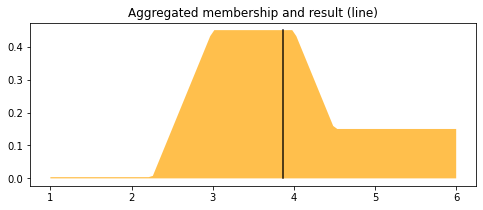

In [27]:
# Define fuzzy control system
rules = [rule1, rule2, rule3, rule4, rule5, rule6, rule7, rule8, rule9]
sim = fuzzySystem([temp_T1,temp_T2],n_safety,rules)

# Compute for given inputs
inputs = {'T1' : 370, 'T2' : 580,}
n_safety_value, aggregate, n_safety_activation = sim.compute(inputs, normalize=True)

# Visualize this
fig, ax0 = plt.subplots(figsize=(8, 3))

n_0 = np.zeros_like(n_safety.universe)

ax0.fill_between(n_safety.universe, n_0, aggregate, facecolor='Orange', alpha=0.7)
ax0.plot([n_safety_value, n_safety_value], [0, n_safety_activation], 'k', linewidth=1.5, alpha=0.9)
ax0.set_title('Aggregated membership and result (line)')

plt.show()

Next we infer the value of ``n_safety`` for different combinations of ``T1`` and ``T2`` by sweeping over them

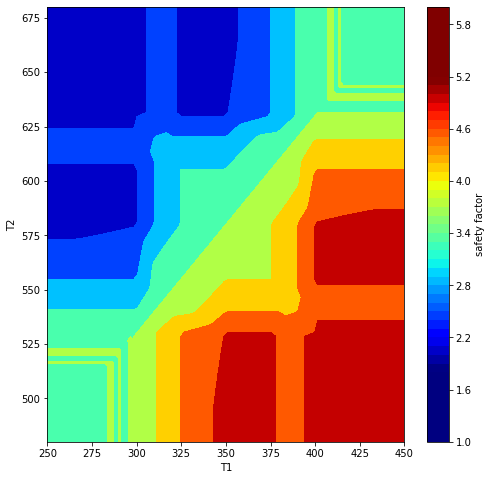

In [29]:
# Simulate at higher resolution the control space in 2D
x, y = np.meshgrid(universe[:,0], universe[:,1])
z = np.zeros_like(x)

# Loop through the system to collect the control surface
for i in range(len(universe)):
    for j in range(len(universe)):
        inputs = {'T1' : x[i, j], 'T2' : y[i, j],}
        z[i, j],_,_ = sim.compute(inputs)

# Plot the result in 2D
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot()

surf = ax.contourf(x, y, z, cmap=plt.cm.jet,)
ax.set_xlabel('T1')
ax.set_ylabel('T2')

cbar = plt.cm.ScalarMappable(cmap=plt.cm.jet)
cbar.set_array(z)

boundaries = np.linspace(1, 6, 51)
cbar_h = fig.colorbar(cbar, boundaries=boundaries)
cbar_h.set_label('safety factor', rotation=90, labelpad=3)

plt.show()